In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import time
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime

# Deep Learning imports
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
    from tensorflow.keras.applications import (
        MobileNetV2, EfficientNetB0, ResNet50V2,
        DenseNet121, Xception
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Enable mixed precision for better GPU utilization
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
    print("Mixed precision enabled for better GPU efficiency")

except ImportError:
    print("TensorFlow not available - please install: pip install tensorflow")
    exit()

# ML evaluation imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                           confusion_matrix, f1_score, precision_score, recall_score)

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

TensorFlow version: 2.19.0
GPU available: True
Mixed precision enabled for better GPU efficiency
All libraries imported successfully!


In [2]:
class Config:
    """Optimized configuration for transfer learning"""

    # Detect environment and set appropriate paths
    import sys
    IS_COLAB = 'google.colab' in sys.modules

    if IS_COLAB:
        # Google Colab paths
        BASE_PATH = Path('/content/drive/MyDrive/data')
        OUTPUT_BASE = Path('/content/drive/MyDrive/output')
        print("Running in Google Colab environment")
    else:
        # Local development paths
        BASE_PATH = Path('./data')
        OUTPUT_BASE = Path('./output')
        print("Running in local environment")

    # Image parameters (smaller for efficiency)
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    IMG_CHANNELS = 3
    SUPPORTED_IMG_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

    # Training parameters (optimized for efficiency)
    BATCH_SIZE = 8  # Small batch size for limited GPU memory
    EPOCHS = 20     # Fewer epochs for transfer learning
    LEARNING_RATE = 0.001
    PATIENCE = 7

    # Transfer learning parameters
    FREEZE_LAYERS = True
    FINE_TUNE_EPOCHS = 10
    FINE_TUNE_LR = 0.0001

    # Data augmentation (lighter)
    ROTATION_RANGE = 15
    ZOOM_RANGE = 0.1
    HORIZONTAL_FLIP = True

    # Output paths
    OUTPUT_DIR = OUTPUT_BASE
    MODEL_DIR = OUTPUT_DIR / 'models'

Running in Google Colab environment


In [3]:
def setup_directories():
    for dir_path in [Config.OUTPUT_DIR, Config.MODEL_DIR]:
        dir_path.mkdir(parents=True, exist_ok=True)

    if Config.IS_COLAB:
        print("🔧 Google Colab setup complete")
        print(f"📁 Data directory: {Config.BASE_PATH}")
        print(f"📁 Output directory: {Config.OUTPUT_DIR}")
        print("📋 To upload data in Colab:")
        print("   1. Upload zip file containing your data")
        print("   2. Extract to /content/data/")
        print("   3. Ensure structure: /content/data/20mm/contours/, /content/data/25mm/contours/, etc.")

setup_directories()
print(f"Using efficient config optimized for limited GPU resources")
print(f"Batch size: {Config.BATCH_SIZE}, Image size: {Config.IMG_HEIGHT}x{Config.IMG_WIDTH}")

🔧 Google Colab setup complete
📁 Data directory: /content/drive/MyDrive/data
📁 Output directory: /content/drive/MyDrive/output
📋 To upload data in Colab:
   1. Upload zip file containing your data
   2. Extract to /content/data/
   3. Ensure structure: /content/data/20mm/contours/, /content/data/25mm/contours/, etc.
Using efficient config optimized for limited GPU resources
Batch size: 8, Image size: 224x224


In [4]:
class EfficientImageLoader:
    """Memory-efficient image loading"""

    def __init__(self, max_images_per_class=150):
        self.max_images_per_class = max_images_per_class
        self.class_names = ['No Leak', 'Leak']

    def discover_images(self):
        """Discover thermal images in contours folders"""
        print("Discovering thermal images in contours folders...")
        all_images = []

        for hole_size in ['20mm', '25mm', '30mm', '40mm']:
            hole_path = Config.BASE_PATH / hole_size

            if not hole_path.exists():
                print(f"  Directory not found: {hole_path}")
                continue

            # Look specifically in contours subdirectory
            contours_path = hole_path / 'contours'
            if contours_path.exists():
                print(f"  Searching in: {contours_path}")

                # Find all image files in contours folder
                found_in_folder = 0
                for ext in Config.SUPPORTED_IMG_FORMATS:
                    images_with_ext = list(contours_path.glob(f'*{ext}'))
                    images_with_ext.extend(list(contours_path.glob(f'*{ext.upper()}')))
                    all_images.extend(images_with_ext)
                    found_in_folder += len(images_with_ext)

                print(f"    Found {found_in_folder} images in {hole_size}/contours/")
            else:
                print(f"  Contours folder not found: {contours_path}")

        print(f"Total images discovered: {len(all_images)}")
        return all_images

    def create_balanced_dataset(self, image_paths):
        """Create balanced dataset with labels"""
        print("Creating balanced dataset...")

        leak_images = []
        no_leak_images = []

        for img_path in image_paths:
            # Simple labeling based on hole size in path
            hole_size = None
            for size in ['20mm', '25mm', '30mm', '40mm']:
                if size in str(img_path):
                    hole_size = int(size.replace('mm', ''))
                    break

            if hole_size is None:
                continue

            # Classify as leak if hole size > 25mm
            if hole_size > 25:
                if len(leak_images) < self.max_images_per_class:
                    leak_images.append((str(img_path), 1))
            else:
                if len(no_leak_images) < self.max_images_per_class:
                    no_leak_images.append((str(img_path), 0))

        # Combine and shuffle
        all_data = leak_images + no_leak_images
        np.random.shuffle(all_data)

        paths, labels = zip(*all_data) if all_data else ([], [])

        print(f"Balanced dataset: {len(leak_images)} leak, {len(no_leak_images)} no-leak")
        return list(paths), list(labels)

    def load_images_efficiently(self, image_paths, labels):
        """Load images with memory efficiency"""
        print(f"Loading {len(image_paths)} images efficiently...")

        images = []
        valid_labels = []
        valid_paths = []

        for i, (path, label) in enumerate(zip(image_paths, labels)):
            try:
                img = load_img(path, target_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH))
                img_array = img_to_array(img) / 255.0

                images.append(img_array)
                valid_labels.append(label)
                valid_paths.append(path)

                if (i + 1) % 50 == 0:
                    print(f"  Loaded {i + 1}/{len(image_paths)} images")

            except Exception as e:
                print(f"  Skipped {Path(path).name}: {e}")
                continue

        if images:
            print(f"Successfully loaded {len(images)} images")
            return np.array(images), np.array(valid_labels), valid_paths
        else:
            return np.array([]), np.array([]), []


In [5]:
loader = EfficientImageLoader(max_images_per_class=200)
discovered_paths = loader.discover_images()

if len(discovered_paths) == 0:
    print("No images found! Please ensure images are in ./data/ directory")
    X_images, y_images, image_paths = np.array([]), np.array([]), []
else:
    balanced_paths, balanced_labels = loader.create_balanced_dataset(discovered_paths)
    X_images, y_images, image_paths = loader.load_images_efficiently(balanced_paths, balanced_labels)

Discovering thermal images in contours folders...
  Searching in: /content/drive/MyDrive/data/20mm/contours
    Found 63 images in 20mm/contours/
  Searching in: /content/drive/MyDrive/data/25mm/contours
    Found 62 images in 25mm/contours/
  Searching in: /content/drive/MyDrive/data/30mm/contours
    Found 22 images in 30mm/contours/
  Searching in: /content/drive/MyDrive/data/40mm/contours
    Found 21 images in 40mm/contours/
Total images discovered: 168
Creating balanced dataset...
Balanced dataset: 43 leak, 125 no-leak
Loading 168 images efficiently...
  Loaded 50/168 images
  Loaded 100/168 images
  Loaded 150/168 images
Successfully loaded 168 images



Dataset Statistics:
  Total images: 168
  Leak samples: 43 (25.6%)
  No leak samples: 125 (74.4%)


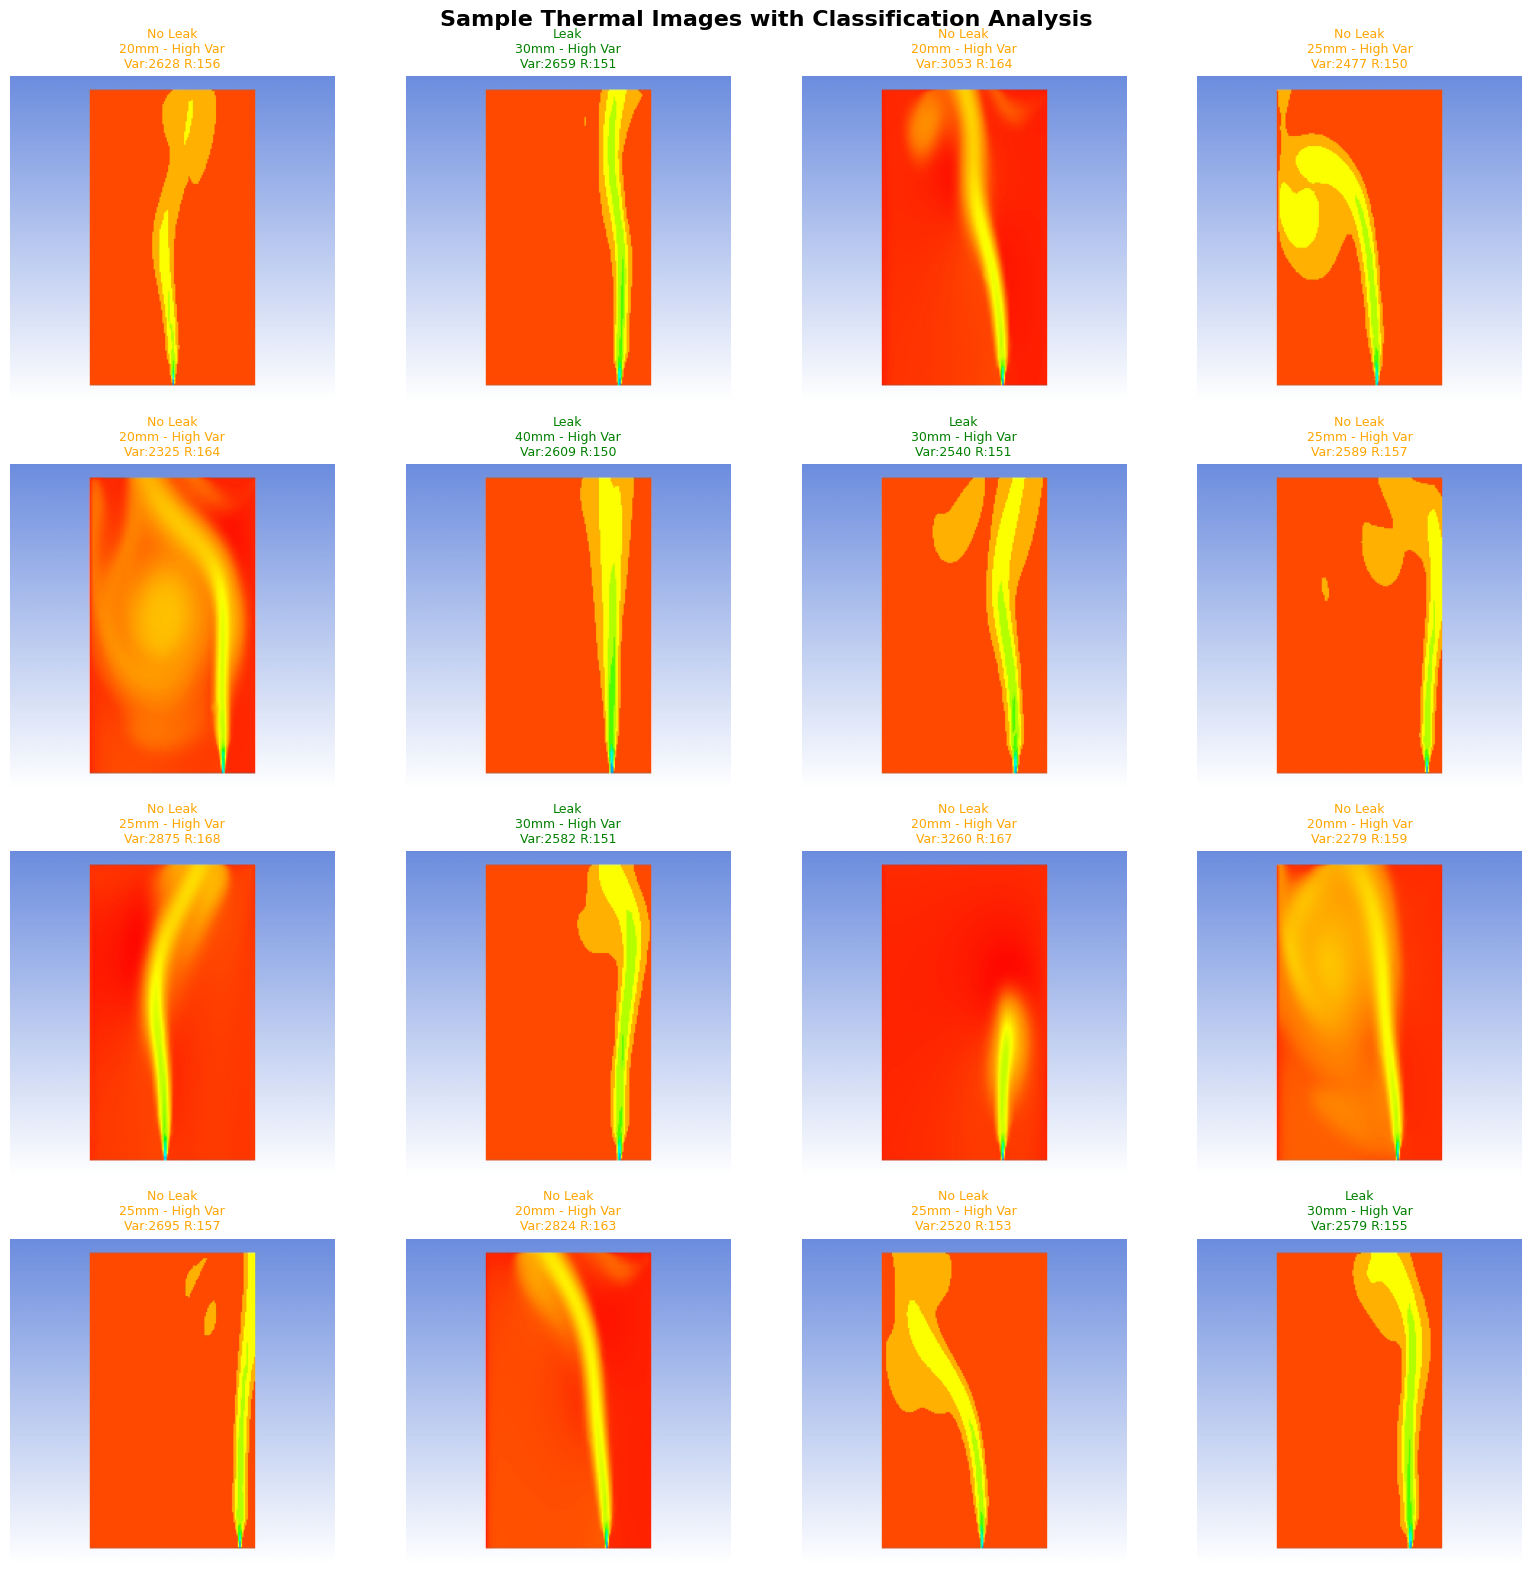

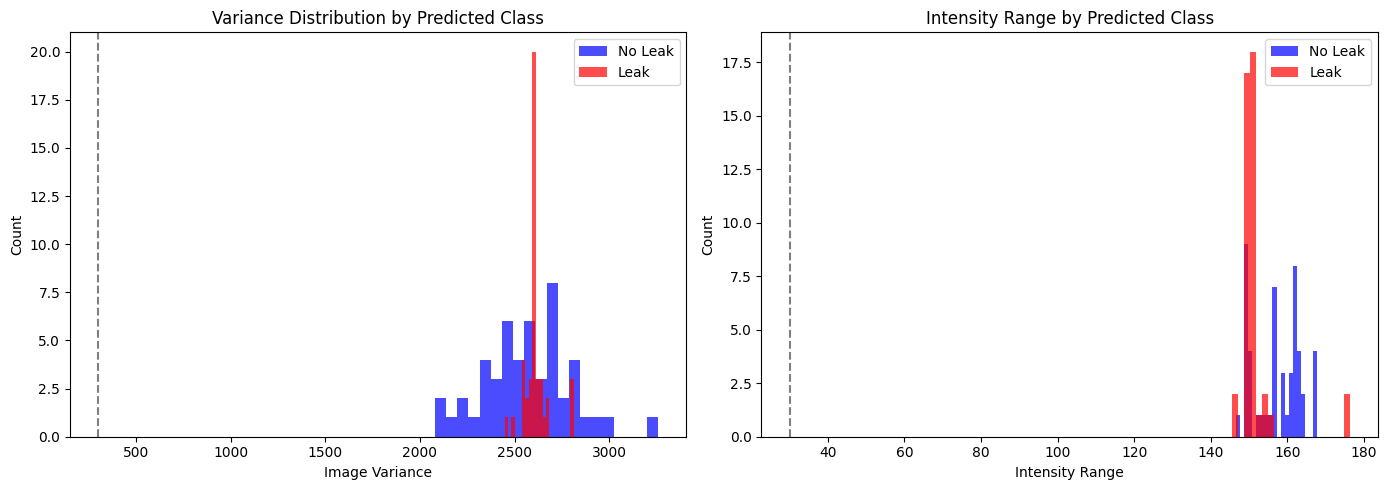


📊 Classification Quality Assessment:
Green titles = Likely correct classifications
Orange titles = Questionable classifications

Expected patterns:
- No Leak images should have low variance (<300) and small range (<30)
- Leak images should have high variance (>600) or visible patterns

Actual averages:
- Predicted No Leak avg variance: 2562
- Predicted Leak avg variance: 2612
- Predicted No Leak avg range: 158
- Predicted Leak avg range: 152


In [7]:
if len(X_images) > 0:
    print(f"\nDataset Statistics:")
    print(f"  Total images: {len(X_images)}")
    print(f"  Leak samples: {np.sum(y_images == 1)} ({np.mean(y_images == 1):.1%})")
    print(f"  No leak samples: {np.sum(y_images == 0)} ({np.mean(y_images == 0):.1%})")

    # Enhanced sample visualization with classification details
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Sample Thermal Images with Classification Analysis', fontsize=16, fontweight='bold')

    # Show random samples to verify classification quality
    sample_indices = np.random.choice(len(X_images), min(16, len(X_images)), replace=False)

    for i, idx in enumerate(sample_indices):
        row, col = i // 4, i % 4
        ax = axes[row, col]

        # Show image
        ax.imshow(X_images[idx])

        # Get original image path to analyze features
        img_path = image_paths[idx]
        hole_size = None
        for size in ['20mm', '25mm', '30mm', '40mm']:
            if size in str(img_path):
                hole_size = size
                break

        # Analyze image features for verification
        img_array = (X_images[idx] * 255).astype(np.uint8)
        gray = np.mean(img_array, axis=2)
        variance = np.var(gray)
        intensity_range = np.max(gray) - np.min(gray)

        # Current label
        predicted_label = "Leak" if y_images[idx] == 1 else "No Leak"

        # Visual assessment hints
        if variance < 200 and intensity_range < 30:
            visual_hint = "Uniform"
        elif variance > 800:
            visual_hint = "High Var"
        else:
            visual_hint = "Moderate"

        title = f"{predicted_label}\n{hole_size} - {visual_hint}\nVar:{variance:.0f} R:{intensity_range:.0f}"

        # Color code the title based on likely correctness
        if predicted_label == "No Leak" and variance < 300:
            title_color = 'green'  # Likely correct
        elif predicted_label == "Leak" and variance > 600:
            title_color = 'green'  # Likely correct
        else:
            title_color = 'orange'  # Questionable

        ax.set_title(title, fontsize=9, color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Show distribution of features by predicted class
    leak_indices = np.where(y_images == 1)[0]
    no_leak_indices = np.where(y_images == 0)[0]

    if len(leak_indices) > 0 and len(no_leak_indices) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Calculate variances for each class
        leak_variances = []
        no_leak_variances = []

        for idx in leak_indices[:50]:  # Sample to avoid slowness
            img_array = (X_images[idx] * 255).astype(np.uint8)
            gray = np.mean(img_array, axis=2)
            leak_variances.append(np.var(gray))

        for idx in no_leak_indices[:50]:
            img_array = (X_images[idx] * 255).astype(np.uint8)
            gray = np.mean(img_array, axis=2)
            no_leak_variances.append(np.var(gray))

        # Plot variance distributions
        ax1.hist(no_leak_variances, bins=20, alpha=0.7, label='No Leak', color='blue')
        ax1.hist(leak_variances, bins=20, alpha=0.7, label='Leak', color='red')
        ax1.set_xlabel('Image Variance')
        ax1.set_ylabel('Count')
        ax1.set_title('Variance Distribution by Predicted Class')
        ax1.legend()
        ax1.axvline(x=300, color='black', linestyle='--', alpha=0.5, label='Low variance threshold')

        # Calculate ranges for each class
        leak_ranges = []
        no_leak_ranges = []

        for idx in leak_indices[:50]:
            img_array = (X_images[idx] * 255).astype(np.uint8)
            gray = np.mean(img_array, axis=2)
            leak_ranges.append(np.max(gray) - np.min(gray))

        for idx in no_leak_indices[:50]:
            img_array = (X_images[idx] * 255).astype(np.uint8)
            gray = np.mean(img_array, axis=2)
            no_leak_ranges.append(np.max(gray) - np.min(gray))

        # Plot range distributions
        ax2.hist(no_leak_ranges, bins=20, alpha=0.7, label='No Leak', color='blue')
        ax2.hist(leak_ranges, bins=20, alpha=0.7, label='Leak', color='red')
        ax2.set_xlabel('Intensity Range')
        ax2.set_ylabel('Count')
        ax2.set_title('Intensity Range by Predicted Class')
        ax2.legend()
        ax2.axvline(x=30, color='black', linestyle='--', alpha=0.5, label='Low range threshold')

        plt.tight_layout()
        plt.show()

        # Print classification quality assessment
        print("\n📊 Classification Quality Assessment:")
        print("Green titles = Likely correct classifications")
        print("Orange titles = Questionable classifications")
        print("\nExpected patterns:")
        print("- No Leak images should have low variance (<300) and small range (<30)")
        print("- Leak images should have high variance (>600) or visible patterns")
        print(f"\nActual averages:")
        if leak_variances and no_leak_variances:
            print(f"- Predicted No Leak avg variance: {np.mean(no_leak_variances):.0f}")
            print(f"- Predicted Leak avg variance: {np.mean(leak_variances):.0f}")
            print(f"- Predicted No Leak avg range: {np.mean(no_leak_ranges):.0f}")
            print(f"- Predicted Leak avg range: {np.mean(leak_ranges):.0f}")

else:
    print("No images available for visualization")

In [8]:
class EfficientTransferModels:
    """GPU-efficient transfer learning models"""

    @staticmethod
    def create_transfer_model(base_name='MobileNetV2', num_classes=1):
        """Create efficient transfer learning model"""
        print(f"Creating {base_name} transfer learning model...")

        # Define base models (sorted by efficiency)
        base_models = {
            'MobileNetV2': MobileNetV2,
            'EfficientNetB0': EfficientNetB0,
            'DenseNet121': DenseNet121,
            'ResNet50V2': ResNet50V2,
        }

        if base_name not in base_models:
            raise ValueError(f"Unsupported model: {base_name}")

        # Load pretrained base model
        base_model = base_models[base_name](
            weights='imagenet',
            include_top=False,
            input_shape=(Config.IMG_HEIGHT, Config.IMG_WIDTH, Config.IMG_CHANNELS)
        )

        # Freeze base model layers
        if Config.FREEZE_LAYERS:
            base_model.trainable = False

        # Add efficient classification head
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='sigmoid', dtype='float32')  # float32 for final layer
        ], name=f'Transfer_{base_name}')

        print(f"Model created: {model.count_params():,} total parameters")
        trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
        print(f"Trainable parameters: {trainable_params:,}")

        return model, base_model

In [9]:
def create_efficient_models():
    """Create multiple efficient transfer learning models"""
    models_dict = {}

    # Prioritize by efficiency (GPU memory and speed)
    efficient_models = ['MobileNetV2', 'EfficientNetB0', 'DenseNet121']

    for model_name in efficient_models:
        try:
            model, base_model = EfficientTransferModels.create_transfer_model(model_name)
            models_dict[model_name] = {
                'model': model,
                'base_model': base_model,
                'params': model.count_params()
            }
            print(f"✅ {model_name} ready")
        except Exception as e:
            print(f"❌ Failed to create {model_name}: {e}")

    return models_dict

if len(X_images) > 0:
    efficient_models = create_efficient_models()
    print(f"\nCreated {len(efficient_models)} efficient models")
else:
    print("Skipping model creation - no images available")

Creating MobileNetV2 transfer learning model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created: 2,422,593 total parameters
Trainable parameters: 164,353
✅ MobileNetV2 ready
Creating EfficientNetB0 transfer learning model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created: 4,214,180 total parameters
Trainable parameters: 164,353
✅ EfficientNetB0 ready
Creating DenseNet121 transfer learning model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created: 7,169,345 total parameters
Trainable parameters: 131,585
✅ DenseNet121 ready

Created 3 efficient models


In [10]:
def create_efficient_generators():
    """Create lightweight data augmentation"""
    train_datagen = ImageDataGenerator(
        rotation_range=Config.ROTATION_RANGE,
        zoom_range=Config.ZOOM_RANGE,
        horizontal_flip=Config.HORIZONTAL_FLIP,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()  # No augmentation for validation

    return train_datagen, val_datagen

In [11]:
class FastTrainer:
    """Fast and efficient training pipeline"""

    def __init__(self):
        self.models = {}
        self.histories = {}
        self.results = {}

    def prepare_data(self, X, y):
        """Efficient data preparation"""
        print("Preparing data...")

        # Simple train/validation/test split
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
        )

        print(f"  Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def create_callbacks(self, model_name):
        """Lightweight callbacks"""
        return [
            EarlyStopping(monitor='val_accuracy', patience=Config.PATIENCE, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]

    def train_model_fast(self, model_info, model_name, train_data, val_data):
        """Fast training with transfer learning"""
        print(f"\n🚀 Training {model_name}...")

        model = model_info['model']
        X_train, y_train = train_data
        X_val, y_val = val_data

        # Compile with efficient settings
        model.compile(
            optimizer=Adam(learning_rate=Config.LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Create data generators
        train_gen, val_gen = create_efficient_generators()

        # Train with generators for memory efficiency
        start_time = time.time()

        history = model.fit(
            train_gen.flow(X_train, y_train, batch_size=Config.BATCH_SIZE),
            steps_per_epoch=len(X_train) // Config.BATCH_SIZE,
            epochs=Config.EPOCHS,
            validation_data=val_gen.flow(X_val, y_val, batch_size=Config.BATCH_SIZE),
            validation_steps=len(X_val) // Config.BATCH_SIZE,
            callbacks=self.create_callbacks(model_name),
            verbose=1
        )

        training_time = time.time() - start_time

        # Store results
        self.models[model_name] = model
        self.histories[model_name] = history

        best_val_acc = max(history.history['val_accuracy'])
        self.results[model_name] = {
            'val_accuracy': best_val_acc,
            'training_time': training_time,
            'epochs': len(history.history['loss'])
        }

        print(f"✅ {model_name}: {best_val_acc:.3f} accuracy in {training_time:.1f}s")

        # Clear GPU memory
        tf.keras.backend.clear_session()

        return history

    def evaluate_models(self, test_data):
        """Quick evaluation on test set"""
        X_test, y_test = test_data
        test_results = {}

        print("\n🧪 Evaluating models on test set...")

        for model_name, model in self.models.items():
            y_pred_proba = model.predict(X_test, batch_size=Config.BATCH_SIZE, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()

            test_results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
            }

            print(f"  {model_name}: {test_results[model_name]['accuracy']:.3f} accuracy")

        return test_results

In [12]:
if len(X_images) > 0 and 'efficient_models' in locals():
    print("\n" + "="*50)
    print("🚀 FAST TRAINING WITH TRANSFER LEARNING")
    print("="*50)

    trainer = FastTrainer()
    train_data, val_data, test_data = trainer.prepare_data(X_images, y_images)

    # Train models (one at a time to save GPU memory)
    for model_name, model_info in efficient_models.items():
        trainer.train_model_fast(model_info, model_name, train_data, val_data)

        # Force garbage collection between models
        import gc
        gc.collect()
        tf.keras.backend.clear_session()

    # Evaluate all models
    test_results = trainer.evaluate_models(test_data)

    # Find best model
    best_model = max(test_results.keys(), key=lambda x: test_results[x]['accuracy'])
    print(f"\n🏆 Best model: {best_model} ({test_results[best_model]['accuracy']:.3f} accuracy)")

else:
    print("Skipping training - no images or models available")


🚀 FAST TRAINING WITH TRANSFER LEARNING
Preparing data...
  Train: 100, Val: 34, Test: 34

🚀 Training MobileNetV2...
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6111 - loss: 0.6679 - val_accuracy: 0.7500 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7500 - loss: 1.0016 - val_accuracy: 0.7500 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6348 - loss: 0.7114 - val_accuracy: 0.7188 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 0.8606 - val_accuracy: 0.7188 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6711 - loss: 0.5790 - val_accuracy: 0.7188 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.2137 - val_accuracy: 0.7188 - val_loss: 0.4743 - le

  DenseNet121: 0.765 accuracy

🏆 Best model: MobileNetV2 (0.824 accuracy)


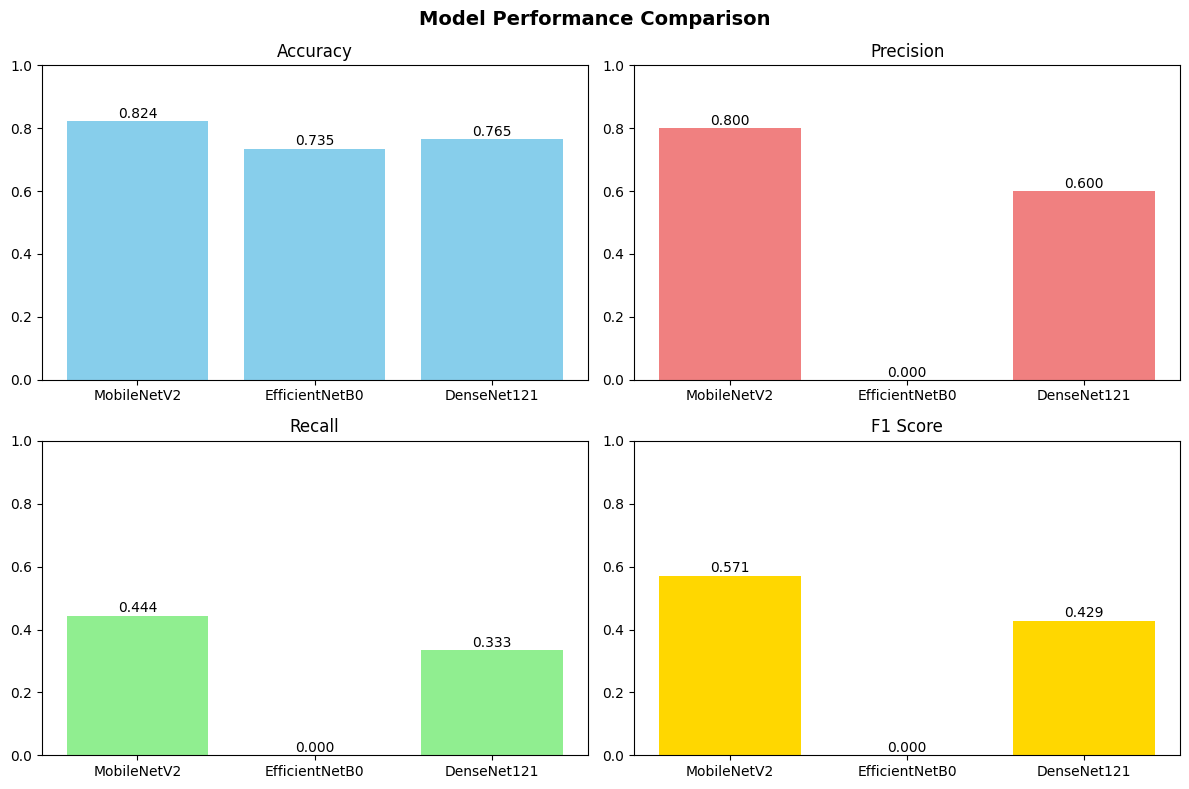

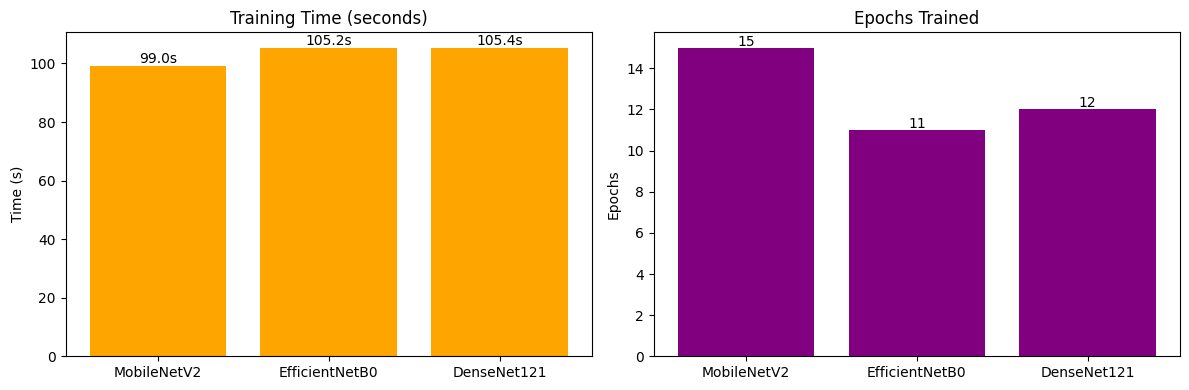

In [13]:
if len(X_images) > 0 and 'test_results' in locals():
    # Performance comparison
    models = list(test_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')

    # Accuracy
    acc_scores = [test_results[m]['accuracy'] for m in models]
    ax1.bar(models, acc_scores, color='skyblue')
    ax1.set_title('Accuracy')
    ax1.set_ylim(0, 1)
    for i, v in enumerate(acc_scores):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Precision
    prec_scores = [test_results[m]['precision'] for m in models]
    ax2.bar(models, prec_scores, color='lightcoral')
    ax2.set_title('Precision')
    ax2.set_ylim(0, 1)
    for i, v in enumerate(prec_scores):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Recall
    rec_scores = [test_results[m]['recall'] for m in models]
    ax3.bar(models, rec_scores, color='lightgreen')
    ax3.set_title('Recall')
    ax3.set_ylim(0, 1)
    for i, v in enumerate(rec_scores):
        ax3.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # F1 Score
    f1_scores = [test_results[m]['f1_score'] for m in models]
    ax4.bar(models, f1_scores, color='gold')
    ax4.set_title('F1 Score')
    ax4.set_ylim(0, 1)
    for i, v in enumerate(f1_scores):
        ax4.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Training efficiency comparison
    if trainer.results:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Training time
        times = [trainer.results[m]['training_time'] for m in models]
        ax1.bar(models, times, color='orange')
        ax1.set_title('Training Time (seconds)')
        ax1.set_ylabel('Time (s)')
        for i, v in enumerate(times):
            ax1.text(i, v + max(times)*0.01, f'{v:.1f}s', ha='center')

        # Epochs trained
        epochs = [trainer.results[m]['epochs'] for m in models]
        ax2.bar(models, epochs, color='purple')
        ax2.set_title('Epochs Trained')
        ax2.set_ylabel('Epochs')
        for i, v in enumerate(epochs):
            ax2.text(i, v + 0.1, f'{v}', ha='center')

        plt.tight_layout()
        plt.show()

In [14]:
def save_best_model(trainer, test_results, best_model):
    """Save the best model with info"""
    if not trainer.models or not test_results:
        print("No models to save")
        return None, None

    # Save best model
    best_model_obj = trainer.models[best_model]
    model_path = Config.MODEL_DIR / f'{best_model}_best.h5'
    best_model_obj.save(model_path)

    # Save model info
    model_info = {
        'model_name': best_model,
        'accuracy': float(test_results[best_model]['accuracy']),
        'precision': float(test_results[best_model]['precision']),
        'recall': float(test_results[best_model]['recall']),
        'f1_score': float(test_results[best_model]['f1_score']),
        'training_time': float(trainer.results[best_model]['training_time']),
        'epochs_trained': int(trainer.results[best_model]['epochs']),
        'image_size': [Config.IMG_HEIGHT, Config.IMG_WIDTH, Config.IMG_CHANNELS],
        'class_names': ['No Leak', 'Leak'],
        'created_date': datetime.now().isoformat()
    }

    info_path = Config.MODEL_DIR / 'model_info.json'
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    print(f"Best model saved: {model_path}")
    print(f"Model info saved: {info_path}")

    return model_path, model_info

# Save models after training
if len(X_images) > 0 and 'trainer' in locals() and 'best_model' in locals():
    model_path, model_info = save_best_model(trainer, test_results, best_model)

Best model saved: /content/drive/MyDrive/output/models/MobileNetV2_best.h5
Model info saved: /content/drive/MyDrive/output/models/model_info.json


Using trained MobileNetV2 model
Preparing data...
  Train: 100, Val: 34, Test: 34


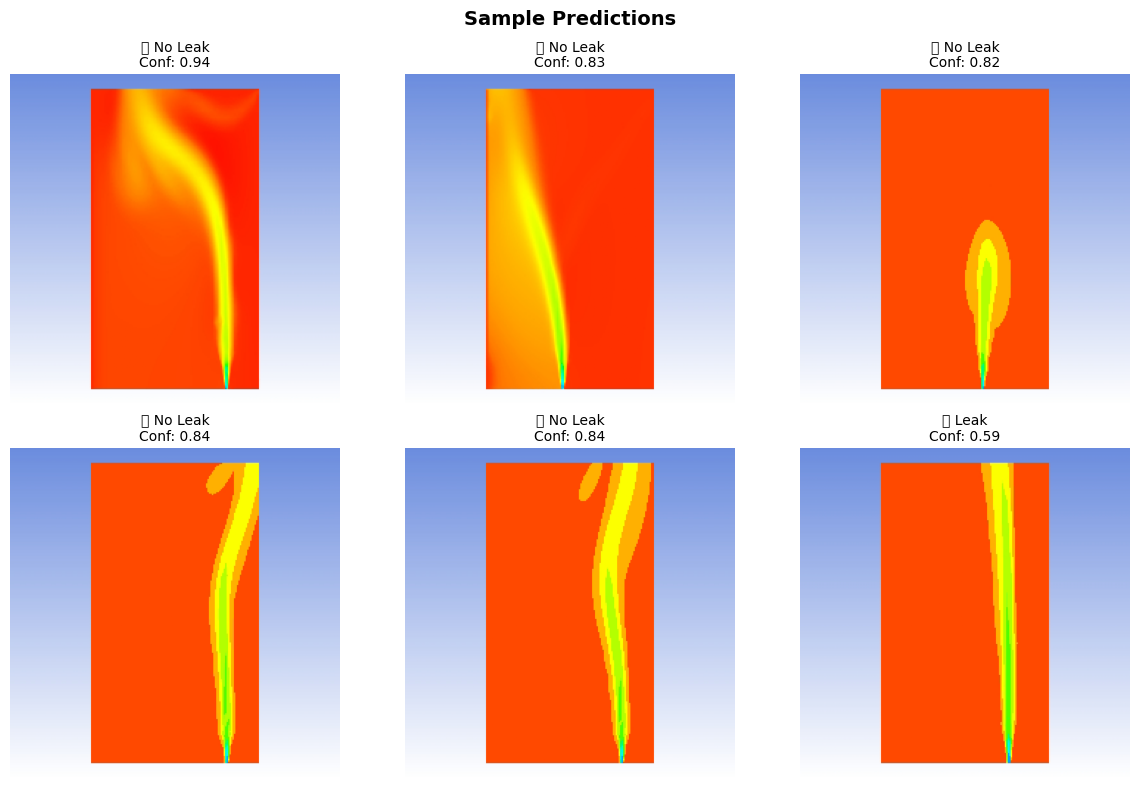


Prediction interface ready!
Usage:
  result = predictor.predict_image('path/to/thermal_image.jpg')
  print(f"Leak detected: {result['leak_detected']}")


In [15]:
class SimplePredictor:
    """Simple prediction interface for deployment"""

    def __init__(self, model=None, model_path=None):
        self.model = None
        self.class_names = ['No Leak', 'Leak']

        # Try to get model from different sources
        if model is not None:
            self.model = model
            print("Using provided model")
        elif model_path and Path(model_path).exists():
            self.model = tf.keras.models.load_model(model_path)
            print(f"Loaded model from {model_path}")
        elif 'trainer' in globals() and hasattr(trainer, 'models') and trainer.models:
            # Use the best trained model
            if hasattr(trainer, 'best_model_name') and trainer.best_model_name:
                self.model = trainer.models[trainer.best_model_name]
                print(f"Using trained {trainer.best_model_name} model")
            else:
                # Use the first available model
                first_model_name = list(trainer.models.keys())[0]
                self.model = trainer.models[first_model_name]
                print(f"Using trained {first_model_name} model")
        else:
            print("No model available - training may not have completed")

    def predict_image(self, image_path):
        """Predict single image"""
        if self.model is None:
            return None

        try:
            # Load and preprocess image
            img = load_img(image_path, target_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH))
            img_array = img_to_array(img) / 255.0
            img_batch = np.expand_dims(img_array, axis=0)

            # Predict
            prediction = self.model.predict(img_batch, verbose=0)[0][0]
            predicted_class = int(prediction > 0.5)
            confidence = prediction if predicted_class else 1 - prediction

            return {
                'leak_detected': bool(predicted_class),
                'confidence': float(confidence),
                'class': self.class_names[predicted_class],
                'raw_score': float(prediction)
            }
        except Exception as e:
            print(f"Error predicting {image_path}: {e}")
            return None

    def test_predictions(self, test_images, num_show=6):
        """Test predictions on sample images"""
        if self.model is None:
            print("No model available for testing")
            return

        sample_indices = np.random.choice(len(test_images), min(num_show, len(test_images)), replace=False)

        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        fig.suptitle('Sample Predictions', fontsize=14, fontweight='bold')
        axes = axes.flatten()

        for i, idx in enumerate(sample_indices):
            if i >= 6:
                break

            # Show image
            axes[i].imshow(test_images[idx])

            # Make prediction (simulate with batch)
            img_batch = np.expand_dims(test_images[idx], axis=0)
            prediction = self.model.predict(img_batch, verbose=0)[0][0]
            predicted_class = int(prediction > 0.5)
            confidence = prediction if predicted_class else 1 - prediction

            # Set title
            emoji = "🔥" if predicted_class else "✅"
            title = f"{emoji} {self.class_names[predicted_class]}\nConf: {confidence:.2f}"
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Create predictor with better error handling
if len(X_images) > 0:
    predictor = SimplePredictor()

    if predictor.model:
        # Test on some images if we have trained models
        if 'trainer' in locals() and hasattr(trainer, 'models'):
            _, _, (X_test, y_test) = trainer.prepare_data(X_images, y_images)
            predictor.test_predictions(X_test, num_show=6)

            print("\nPrediction interface ready!")
            print("Usage:")
            print("  result = predictor.predict_image('path/to/thermal_image.jpg')")
            print("  print(f\"Leak detected: {result['leak_detected']}\")")
        else:
            print("Training data not available for testing")
    else:
        print("No trained model available. Please run the training section first.")

In [16]:
def print_final_summary():
    """Print comprehensive summary"""
    print("\n" + "="*60)
    print("🔥 METHANE LEAK DETECTION - TRANSFER LEARNING SUMMARY")
    print("="*60)

    if len(X_images) > 0:
        print(f"\n📊 DATASET:")
        print(f"  Total images: {len(X_images)}")
        print(f"  Leak samples: {np.sum(y_images == 1)} ({np.mean(y_images == 1):.1%})")
        print(f"  No leak samples: {np.sum(y_images == 0)} ({np.mean(y_images == 0):.1%})")

        if 'efficient_models' in locals():
            print(f"\n🤖 MODELS TRAINED:")
            for name in efficient_models.keys():
                print(f"  ✅ {name}")

        if 'test_results' in locals():
            print(f"\n🏆 BEST PERFORMANCE:")
            print(f"  Model: {best_model}")
            print(f"  Test Accuracy: {test_results[best_model]['accuracy']:.3f}")
            print(f"  Test Precision: {test_results[best_model]['precision']:.3f}")
            print(f"  Test Recall: {test_results[best_model]['recall']:.3f}")
            print(f"  Test F1-Score: {test_results[best_model]['f1_score']:.3f}")

        if 'trainer' in locals() and trainer.results:
            total_time = sum([r['training_time'] for r in trainer.results.values()])
            print(f"\n⚡ EFFICIENCY:")
            print(f"  Total training time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
            print(f"  Average time per model: {total_time/len(trainer.results):.1f} seconds")

    print(f"\n💾 FILES SAVED:")
    print(f"  Models: {Config.MODEL_DIR}")

    if 'model_path' in locals():
        print(f"  Best model: {model_path}")


    print("="*60)
    print("✅ TRANSFER LEARNING COMPLETE!")
    print("="*60)

print_final_summary()


🔥 METHANE LEAK DETECTION - TRANSFER LEARNING SUMMARY

📊 DATASET:
  Total images: 168
  Leak samples: 43 (25.6%)
  No leak samples: 125 (74.4%)

💾 FILES SAVED:
  Models: /content/drive/MyDrive/output/models
✅ TRANSFER LEARNING COMPLETE!
